In [389]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import dask
dask.config.set(scheduler = "single-threaded")

In [424]:
# Load data sets
# --------------------------------------

ds1 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpdlprofwind4newsC1.c1.*.nc',   combine='by_coords', parallel = True)
ds2 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpco2flxwindC1.b1.*.nc',        combine='by_coords', parallel = True)
ds3 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpinterpolatedsondeC1.c1.*.nc', combine='by_coords', parallel = True)
ds4 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpco2flx60mC1.b1.*.nc',         combine='by_coords', parallel = True)

In [425]:
# Get reference dates from each data set
# --------------------------------------

ref_date1 = np.datetime64(datetime(pd.to_datetime(ds1.time[0].values).year, pd.to_datetime(ds1.time[0].values).month, pd.to_datetime(ds1.time[0].values).day))
ref_date2 = np.datetime64(datetime(pd.to_datetime(ds2.time[0].values).year, pd.to_datetime(ds2.time[0].values).month, pd.to_datetime(ds2.time[0].values).day))
ref_date3 = np.datetime64(datetime(pd.to_datetime(ds3.time[0].values).year, pd.to_datetime(ds3.time[0].values).month, pd.to_datetime(ds3.time[0].values).day))
ref_date4 = np.datetime64(datetime(pd.to_datetime(ds4.time[0].values).year, pd.to_datetime(ds4.time[0].values).month, pd.to_datetime(ds4.time[0].values).day))

In [426]:
# Ensure reference dates match
# --------------------------------------

assert(ref_date1 == ref_date2)
assert(ref_date1 == ref_date3)
assert(ref_date1 == ref_date4)

In [427]:
# Compute new time axis
# --------------------------------------

ds1['time'] = ((ds1.time - ref_date1) / np.timedelta64(1, 'D')).values
ds2['time'] = ((ds2.time - ref_date2) / np.timedelta64(1, 'D')).values
ds3['time'] = ((ds3.time - ref_date3) / np.timedelta64(1, 'D')).values
ds4['time'] = ((ds4.time - ref_date4) / np.timedelta64(1, 'D')).values

In [428]:
# Get interpolation values
# --------------------------------------

min_date = max([ds1['time'][0],  ds2['time'][0],  ds3['time'][0],  ds4['time'][0]])
max_date = min([ds1['time'][-1], ds2['time'][-1], ds3['time'][-1], ds4['time'][-1]])

interval = (1/4)/24

common_time = np.arange(min_date, max_date, interval)

In [429]:
# Regularize data sets
# --------------------------------------

ds1 = ds1.interp(time = common_time)
ds2 = ds2.interp(time = common_time)
ds3 = ds3.interp(time = common_time, height = 3000)
ds4 = ds4.interp(time = common_time)

ds_combined = xr.concat([ds2, ds1, ds3], dim = 'height')
ds_combined = ds_combined.sortby('height')

old_u = ds_combined['u'].values
old_v = ds_combined['v'].values

heights     = np.concatenate(([4], [10], np.arange(20, 2000 + 20, 20)))
old_heights = ds_combined['height'].values
new_u       = np.zeros((len(heights), ds_combined['u'].shape[1]))
new_v       = np.zeros((len(heights), ds_combined['v'].shape[1]))

for t in range(new_u.shape[1]):
    inds       = ~np.isnan(old_u[:, t])
    if any(inds == True):
        new_u[:,t] = np.interp(heights, old_heights[inds], old_u[inds, t])
        new_v[:,t] = np.interp(heights, old_heights[inds], old_v[inds, t])

qc_flag_w = np.zeros(common_time.shape)
qc_flag_s = np.zeros(common_time.shape)

total_h = len(old_heights)

surface_quantity = ds4.L.values

for t in range(common_time.shape[0]):
    qc_flag_w[t] = np.sum(np.isnan(old_u[:, t])) / total_h
    qc_flag_s[t] = ~np.isnan(surface_quantity[t])

qc_flag_w = qc_flag_w < 2/3

qc_flag = qc_flag_w * (qc_flag_s).astype(bool)

del ds1
del ds2
del ds3
del old_u
del old_v

ds_new = xr.Dataset({
'u': xr.DataArray(
            data   = new_u[:, qc_flag],   # enter data here
            dims   = ['height', 'time'],
            coords = {'height': heights, 'time': common_time[qc_flag]},
),
'v': xr.DataArray(
            data   = new_v[:, qc_flag],   # enter data here
            dims   = ['height', 'time'],
            coords = {'height': heights, 'time': common_time[qc_flag]},
),
'L': xr.DataArray(
            data   = 1/(ds4.L.values)[qc_flag],   # enter data here
            dims   = ['time'],
            coords = {'time': common_time[qc_flag]},
),
'TKE': xr.DataArray(
            data   = (ds4.TKE.values)[qc_flag],   # enter data here
            dims   = ['time'],
            coords = {'time': common_time[qc_flag]},
),
'hFlux': xr.DataArray(
            data   = (ds4.sh_flux.values)[qc_flag],   # enter data here
            dims   = ['time'],
            coords = {'time': common_time[qc_flag]},
),
'mFlux': xr.DataArray(
            data   = (ds4.mom_flux.values)[qc_flag],   # enter data here
            dims   = ['time'],
            coords = {'time': common_time[qc_flag]},
),
    })

del ds_combined
del ds4
del new_u
del new_v

(0.0, 2000.0)

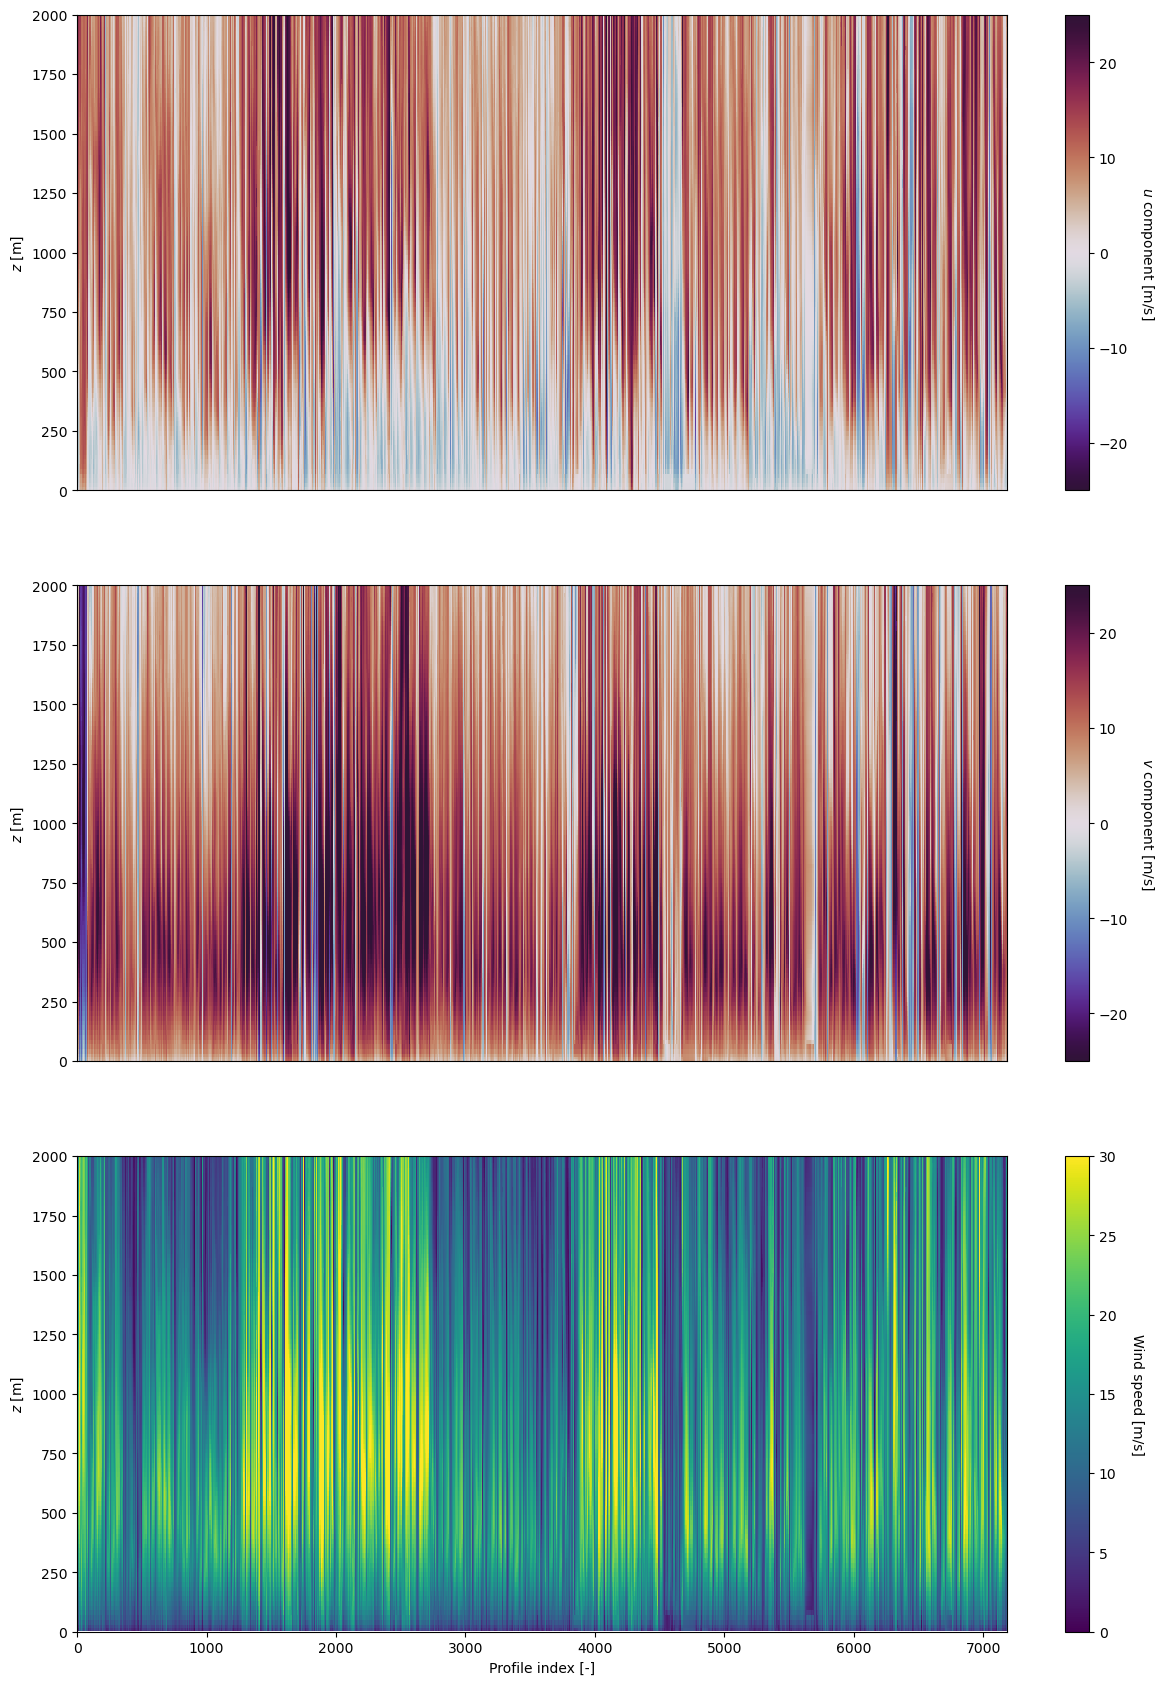

In [430]:
# Plot rectified wind profiles
# --------------------------------------

x_axis = range(len(ds_new.time))
# x_axis = ds_new.time

fig,ax = plt.subplots(3, 1, figsize = (15, 21))

cntf = ax[0].pcolormesh(x_axis, ds_new.height, ds_new.u, vmin = -25, vmax = 25, cmap = 'twilight_shifted')
cbar = plt.colorbar(cntf)
cbar.set_label('$u$ component [m/s]', rotation = 270, labelpad = 20)
ax[0].set_ylabel("$z$ [m]")
ax[0].set_ylim([0, 2000])
ax[0].get_xaxis().set_ticks([])

cntf = ax[1].pcolormesh(x_axis, ds_new.height, ds_new.v, vmin = -25, vmax = 25, cmap = 'twilight_shifted')
cbar = plt.colorbar(cntf)
cbar.set_label('$v$ component [m/s]', rotation = 270, labelpad = 20)
ax[1].set_ylabel("$z$ [m]")
ax[1].set_ylim([0, 2000])
ax[1].get_xaxis().set_ticks([])

cntf = ax[2].pcolormesh(x_axis, ds_new.height, (ds_new.v**2 + ds_new.u**2)**(1/2), vmin = 0, vmax = 30, cmap = 'viridis')
cbar = plt.colorbar(cntf)
cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 20)
ax[2].set_xlabel("Profile index [-]")
ax[2].set_ylabel("$z$ [m]")
ax[2].set_ylim([0, 2000])

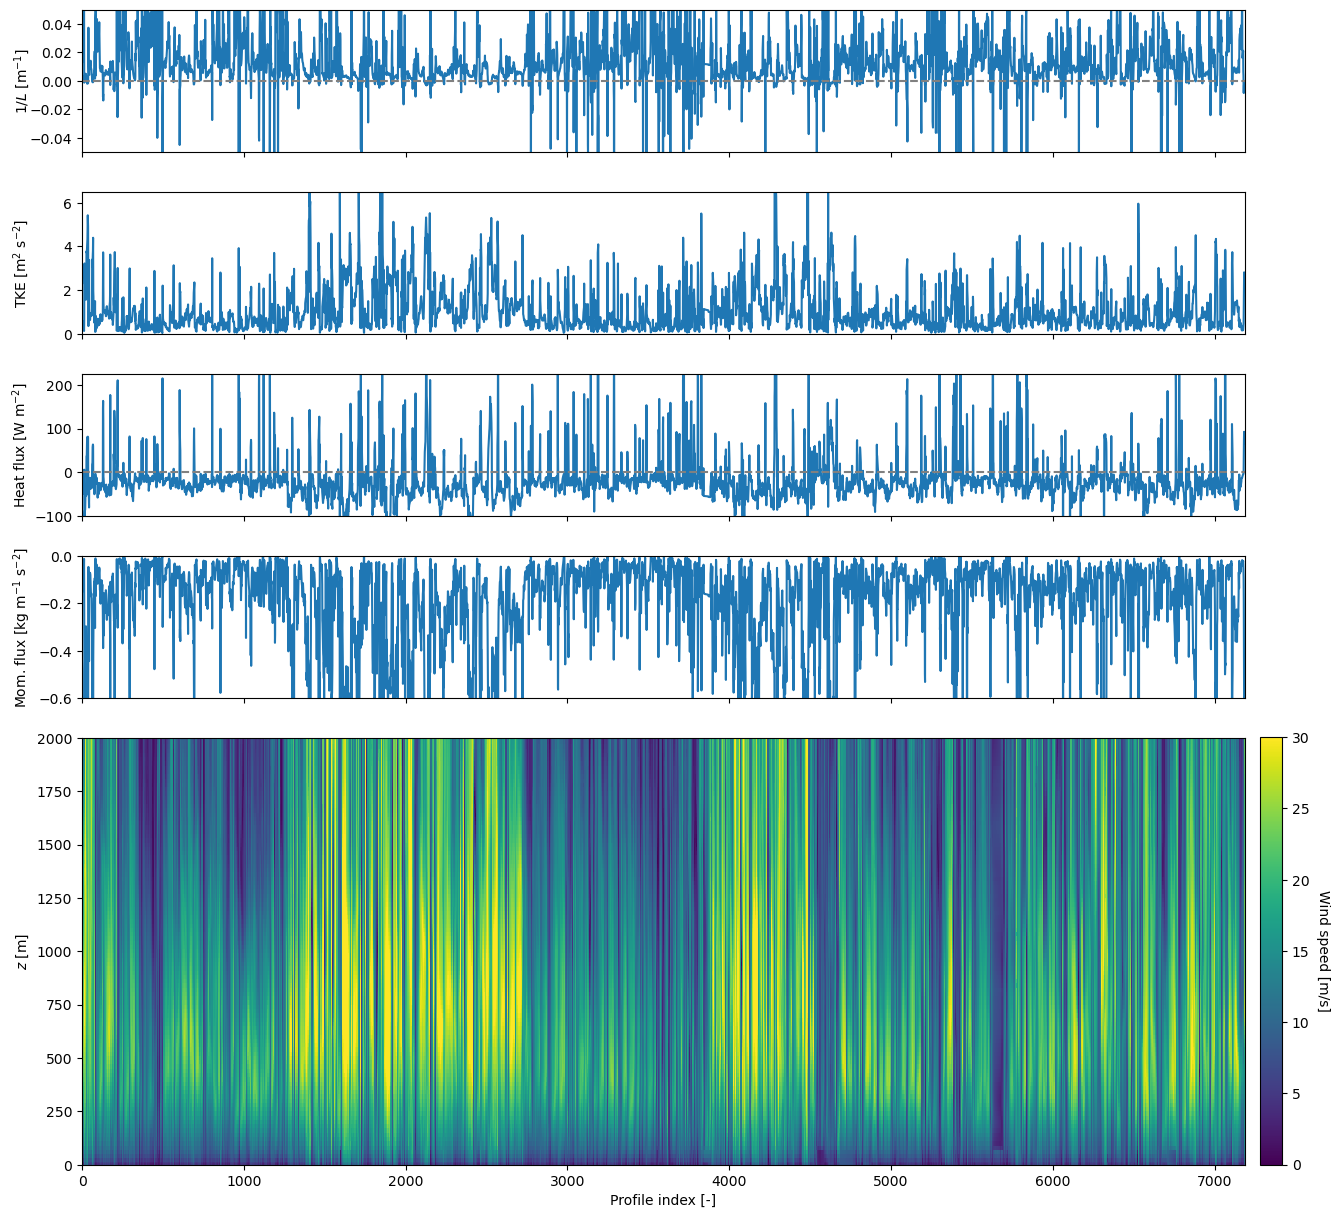

In [431]:
# Plot rectified surface quantities
# --------------------------------------

fig,ax = plt.subplots(5, 1, figsize = (15, 15), gridspec_kw={'height_ratios': [1, 1, 1, 1, 3]}, sharex = True)

ax[0].plot(range(len(ds_new.time)), ds_new.L)
ax[0].set_ylabel("$1/L$ [m$^{-1}$]", labelpad = -2)
# ax[0].get_xaxis().set_ticks([])
ax[0].axhline(y = 0, color = 'grey', linestyle = '--')
ax[0].set_ylim([-0.05, 0.05])
# ax[0].grid()

ax[1].plot(range(len(ds_new.time)), ds_new.TKE)
ax[1].set_ylabel("TKE [m$^2$ s$^{-2}$]", labelpad = 23)
# ax[1].get_xaxis().set_ticks([])
ax[1].set_ylim([0, 6.5])
# ax[1].grid()

ax[2].plot(range(len(ds_new.time)), ds_new.hFlux)
ax[2].set_ylabel("Heat flux [W m$^{-2}$]", labelpad = 3)
# ax[2].get_xaxis().set_ticks([])
ax[2].set_ylim([-100, 225])
ax[2].axhline(y = 0, color = 'grey', linestyle = '--')
# ax[1].grid()

ax[3].plot(range(len(ds_new.time)), ds_new.mFlux)
ax[3].set_ylabel("Mom. flux [kg m$^{-1}$ s$^{-2}$]", labelpad = 4)
# ax[3].get_xaxis().set_ticks([])
ax[3].set_ylim([-0.6, 0])
# ax[1].grid()

cntf = ax[4].pcolormesh(range(len(ds_new.time)), ds_new.height, (ds_new.v**2 + ds_new.u**2)**(1/2), vmin = 0, vmax = 30, cmap = 'viridis')
# cbar = plt.colorbar(cntf)
# cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 20)
ax[4].set_xlabel("Profile index [-]")
ax[4].set_ylabel("$z$ [m]", labelpad = 4)
ax[4].set_ylim([0, 2000])

cb_ax = fig.add_axes([0.91, 0.11, 0.015, 0.285])
cbar = fig.colorbar(cntf, orientation='vertical', cax=cb_ax, )
cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 15)

In [ ]:
# Plot rectified surface quantities
# --------------------------------------

fig,ax = plt.subplots(5, 1, figsize = (11, 15), gridspec_kw={'height_ratios': [1, 1, 1, 1, 3]}, sharex = True)

ax[0].plot(range(len(ds_new.time)), ds_new.L)
ax[0].set_ylabel("$1/L$ [m$^{-1}$]", labelpad = -2)
# ax[0].get_xaxis().set_ticks([])
ax[0].axhline(y = 0, color = 'grey', linestyle = '--')
ax[0].set_ylim([-0.05, 0.05])
# ax[0].grid()

ax[1].plot(range(len(ds_new.time)), ds_new.TKE)
ax[1].set_ylabel("TKE [m$^2$ s$^{-2}$]", labelpad = 23)
# ax[1].get_xaxis().set_ticks([])
ax[1].set_ylim([0, 6.5])
# ax[1].grid()

ax[2].plot(range(len(ds_new.time)), ds_new.hFlux)
ax[2].set_ylabel("Heat flux [W m$^{-2}$]", labelpad = 3)
# ax[2].get_xaxis().set_ticks([])
ax[2].set_ylim([-100, 225])
ax[2].axhline(y = 0, color = 'grey', linestyle = '--')
# ax[1].grid()

ax[3].plot(range(len(ds_new.time)), ds_new.mFlux)
ax[3].set_ylabel("Mom. flux [kg m$^{-1}$ s$^{-2}$]", labelpad = 4)
# ax[3].get_xaxis().set_ticks([])
ax[3].set_ylim([-0.6, 0])
# ax[1].grid()

cntf = ax[4].pcolormesh(range(len(ds_new.time)), ds_new.height, (ds_new.v**2 + ds_new.u**2)**(1/2), vmin = 0, vmax = 30, cmap = 'viridis')
# cbar = plt.colorbar(cntf)
# cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 20)
ax[4].set_xlabel("Profile index [-]")
ax[4].set_ylabel("$z$ [m]", labelpad = 4)
ax[4].set_ylim([0, 2000])

cb_ax = fig.add_axes([0.91, 0.11, 0.015, 0.285])
cbar = fig.colorbar(cntf, orientation='vertical', cax=cb_ax, )
cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 15)

In [1]:
# Plot sample component profiles
# --------------------------------------

fig,ax = plt.subplots(1,3,figsize = (17, 5), sharey = True)

i = 400

ax[0].plot(ds_new.u[:,i], ds_new.height)
ax[0].set_xlabel('$u$ component [m/s]')
ax[0].set_ylabel('$z$ [m]')
# ax[0].set_ylim([0, 50])
ax[0].set_title('Days from reference: ' + str(round(float(ds_new.time[i].values), 2)))

ax[1].plot(ds_new.v[:,i], ds_new.height)
ax[1].set_xlabel('$v$ component [m/s]')
# ax[1].set_ylabel('$z$ [m]')
# ax[1].set_ylim([0, 50])
ax[1].set_title('Days from reference: ' + str(round(float(ds_new.time[i].values), 2)))

ax[2].plot((ds_new.u[:,i]**2 + ds_new.v[:,i]**2)**(1/2), ds_new.height)
ax[2].set_xlabel('Wind speed [m/s]')
# ax[2].set_ylabel('$z$ [m]')
# ax.set_ylim([0, 50])
ax[2].set_title('Days from reference: ' + str(round(float(ds_new.time[i].values), 2)))

NameError: name 'plt' is not defined

In [433]:
# Compute common time axis and cyclical time variables
# --------------------------------------

new_ref_times = np.empty(ds_new.time.shape, dtype = 'datetime64[ns]')
hr_per_day    = np.zeros(new_ref_times.shape)
day_per_yr    = np.zeros(new_ref_times.shape)
times         = ds_new.time.values

for i in range(ds_new.time.shape[0]):
    new_ref_times[i] = np.datetime64((pd.Timestamp(ref_date1) + pd.Timedelta(times[i], 'D')).round('min'))
    hr_per_day[i]    = pd.Timestamp(new_ref_times[i]).hour + pd.Timestamp(new_ref_times[i]).minute/60
    day_per_yr[i]    = new_ref_times[i].astype('datetime64[D]').astype(datetime).timetuple().tm_yday

Text(0, 0.5, 'Day of year')

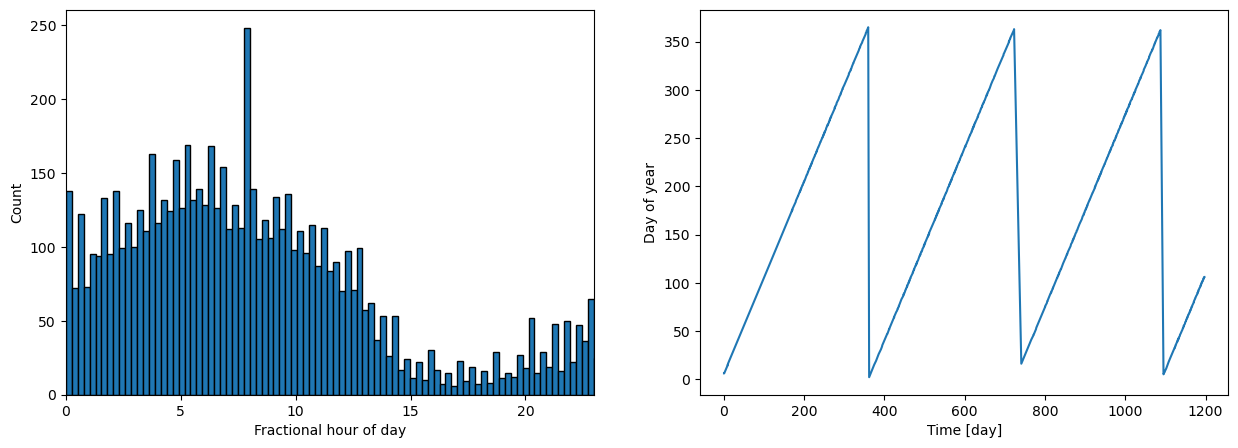

In [434]:
# Confirm time axes are correct
# --------------------------------------

fig,ax = plt.subplots(1,2,figsize = (15, 5))

# ax[0].plot(times, hr_per_day)
ax[0].hist(hr_per_day, bins = 92, edgecolor = 'black')
ax[0].set_xlim([0, 23])
# ax[0].plot(range(len(times)), hr_per_day)
ax[0].set_xlabel('Fractional hour of day')
ax[0].set_ylabel('Count')

ax[1].plot(times, day_per_yr)
# ax[1].plot(range(len(times)), day_per_yr)
ax[1].set_xlabel('Time [day]')
ax[1].set_ylabel('Day of year')

In [435]:
# Save data
# --------------------------------------

ds_new['hr_day'] = (('time'), hr_per_day)
ds_new['day_yr'] = (('time'), day_per_yr)

ds_new.to_netcdf('/Users/smata/Downloads/processedData/velocityData.nc')

ds_new

<xarray.Dataset>
Dimensions:  (height: 102, time: 7185)
Coordinates:
  * height   (height) int64 4 10 20 40 60 80 ... 1900 1920 1940 1960 1980 2000
  * time     (time) float64 1.198 1.208 1.219 ... 1.197e+03 1.197e+03 1.197e+03
Data variables:
    u        (height, time) float64 -2.658 -2.68 -2.702 ... 7.562 6.638 5.857
    v        (height, time) float64 3.672 3.737 3.801 3.786 ... 24.3 23.91 21.92
    L        (time) float64 0.02632 0.02643 0.02654 ... -0.002294 -0.00203
    TKE      (time) float64 0.3641 0.3545 0.3449 0.3402 ... 2.82 2.715 2.611
    hFlux    (time) float64 -31.54 -28.8 -26.06 -28.4 ... 92.61 79.59 66.57
    mFlux    (time) float64 -0.0694 -0.06511 -0.06081 ... -0.6123 -0.5985
    hr_day   (time) float64 4.75 5.0 5.25 5.5 5.75 ... 21.75 23.25 23.5 23.75
    day_yr   (time) float64 6.0 6.0 6.0 6.0 6.0 ... 106.0 106.0 106.0 106.0

Text(0, 0.5, 'Count')

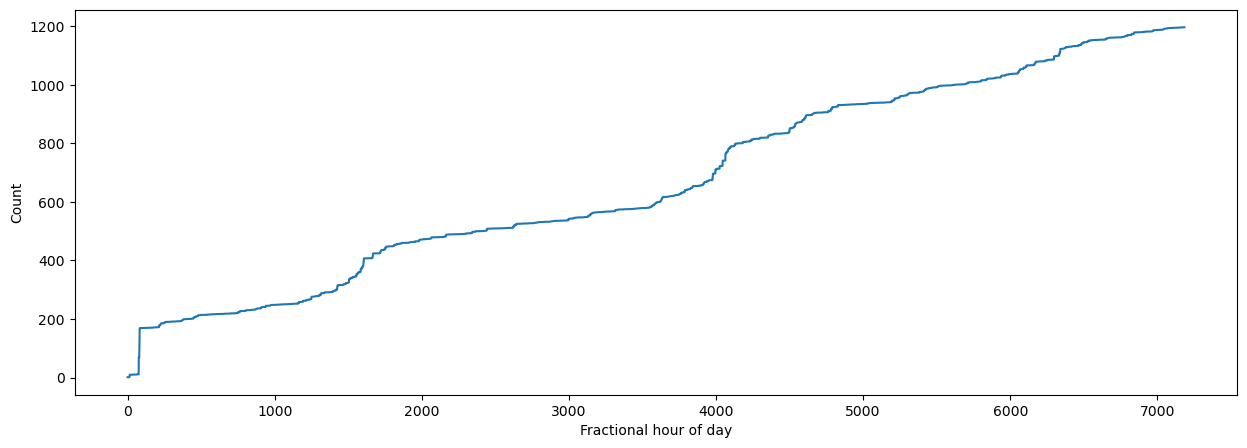

In [436]:
fig,ax = plt.subplots(figsize = (15, 5))

ax.plot(range(len(ds_new.time.values)), ds_new.time.values)
# ax.set_xlim([0, 23])
# ax[0].plot(range(len(times)), hr_per_day)
ax.set_xlabel('Fractional hour of day')
ax.set_ylabel('Count')